# Estimating a model with a known number of events

This section will show you how to estimate a single HMP model with a given number of events, as in the previous tutorial, but now we'll make it more realistic and harder to discover.

First we do more or less the same as in the previous tutorial:
- simulate EEG data
- transform the data
- initialize a model with default parameters for distribution, shape and event duration

We now simulate the data by calling the `demo` function, which is only used for this tutorial.

In [1]:
## Importing the package
import hsmm_mvpy as hmp
#Plotting 
import numpy as np
import matplotlib.pyplot as plt

cpus = 3 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM

## Running the demo function in the simulation module
# Inspect the given function to apply your own simulations
from hsmm_mvpy.simulations import demo
n_events = 8 #how many events to simulate
epoch_data, sim_source_times, info = demo(cpus, n_events)

/home/gweindel/anaconda3/envs/hmpoct/lib/python3.11/site-packages/hsmm_mvpy/simulations.py:165: UserWarning: ./dataset_tutorial2_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


Processing participant ./dataset_tutorial2_raw.fif's continuous eeg
Reading 0 ... 259649  =      0.000 ...  2596.490 secs...
50 trials were retained for participant ./dataset_tutorial2_raw.fif


We specify directly that we want 4 PC components:

In [2]:
hmp_dat = hmp.utils.transform_data(epoch_data, apply_standard=False, n_comp=4)
print(hmp_dat)

<xarray.DataArray (component: 4, all_samples: 4968)>
array([[-0.31519905, -0.40704455, -0.30878602, ...,  2.47001888,
         2.83452298,  2.47210831],
       [-0.0713434 ,  0.17463497,  0.17345811, ...,  0.88418297,
         0.21400743,  0.13506112],
       [ 0.9505224 ,  1.24010193,  1.22506031, ..., -2.1288877 ,
        -1.78280472, -0.98038763],
       [-0.29286626, -0.7309574 , -1.05910115, ..., -0.71388868,
        -0.84519135, -0.70569849]])
Coordinates:
  * component    (component) int64 0 1 2 3
    event_name   (all_samples) object 'stimulus' 'stimulus' ... 'stimulus'
    rt           (all_samples) float64 0.94 0.94 0.94 0.94 ... 1.18 1.18 1.18
  * all_samples  (all_samples) object MultiIndex
  * participant  (all_samples) object 'S0' 'S0' 'S0' 'S0' ... 'S0' 'S0' 'S0'
  * epochs       (all_samples) int64 0 0 0 0 0 0 0 0 ... 49 49 49 49 49 49 49 49
  * samples      (all_samples) int64 0 1 2 3 4 5 6 ... 112 113 114 115 116 117
Attributes:
    pca_weights:  <xarray.DataArray (ch

And we initialize the model:

In [3]:
init = hmp.models.hmp(hmp_dat, sfreq=epoch_data.sfreq, event_width=50, cpus=cpus)#Initialization of the model

Once the class has been initiated, the function ```fit_single()``` can be used to estimate one hmp model with a specified number of transition events

## Direct estimation
As in the previous tutorial, we can simply call the ```fit_single``` method from the hmp class to estimate a given number of events. The hmp algorithm will then look for ```n_event``` events. 

Unfortunately, the expectation maximization algorithm to fit the model is sensitive to the starting points given to the stage duration. By default, the ```fit_single``` method uses a starting point where all events are equally distributed between 0 and the mean RT, and the magnitudes are set to 0.

Estimating 8 events model with 1 starting point(s)
parameters estimated for 8 events model


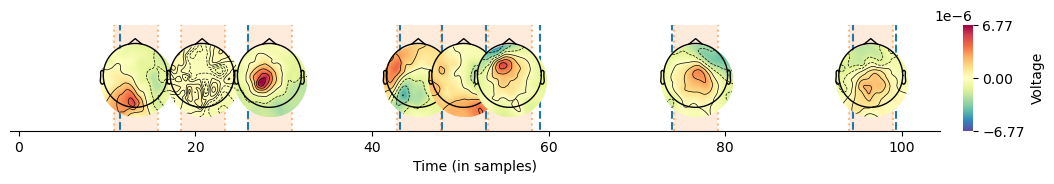

In [4]:
#Fitting
selected = init.fit_single(n_events)#function to fit an instance of a 10 events model

#Visualizing
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

As you can see, the method discovers 8 events - as we told it to - but one of them is at the wrong location (the vertical lines indicate the true event locations).

Thus, launching a single model without additional starting points is not a good idea as sometimes the default starting values of the expectation maximization algorithm will end up in a local minima, as above.

To see what happens if we just use the default inputs and not maximize at all, we can set maximization to False:

Estimating 8 events model with 1 starting point(s)
parameters estimated for 8 events model


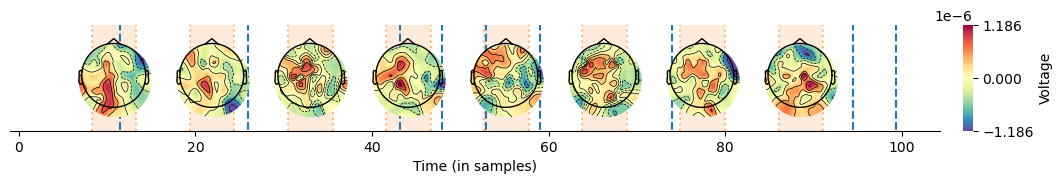

In [5]:
#Fitting
selected = init.fit_single(n_events, maximization=False)#function to fit an instance of a 10 events model

#Visualizing
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, magnify=1, sensors=False, times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

As expected, the 'discovered' events are divided equally over the mean RT. The magnitudes are not 0, as we're plotting the average EEG data at the discovered time points in each trial - as you can see these averages are quite random, and also have very small amplitudes compared to the graph above.

The lesson we learned: we need to use more starting points!

### Exercise 1:

Adapt the cell below to generate starting points on the scale of the gamma parameters to capture all those events. Compare the discovered events to the vertical lines - the onset of the events should overlap with the lines.

Keep in mind that the mean of a gamma is _scale * shape_ 

In [6]:
pars = np.reshape(np.concatenate([
    np.repeat(init.shape, 9), 
    #Following values are our starting points for the stage durations
    [10,10,10,10,10,10,10,10,10]]),#Replace values here- for the exercise
    [2,9]).T
pars

array([[ 2., 10.],
       [ 2., 10.],
       [ 2., 10.],
       [ 2., 10.],
       [ 2., 10.],
       [ 2., 10.],
       [ 2., 10.],
       [ 2., 10.],
       [ 2., 10.]])

Estimating 8 events model
parameters estimated for 8 events model


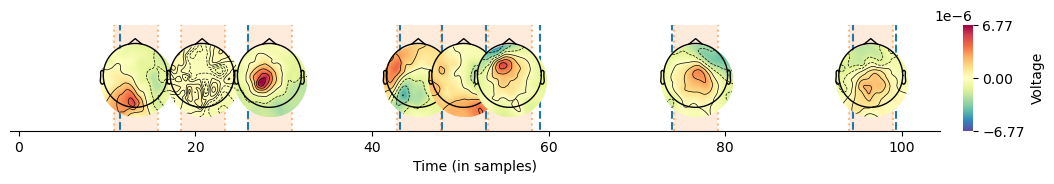

In [7]:
#Fitting
selected = init.fit_single(n_events, parameters=pars)#function to fit an instance of a 10 events model

#Visualizing
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

## Random method

In reality, we do not know where the real events are. Thus, a better idea is to run a single model with several starting points and selecting the result with the best fit. This can be declared in the ```single_fit()``` function; here we estimate an example with 100 random starting points. We set `return_max` to False to get all models back, instead of only the winning one. 

We then sort the models by log-likelihood - how well they explain the EEG data - and plot every 9th model.

Estimating 8 events model with 100 starting point(s)


  0%|          | 0/100 [00:00<?, ?it/s]

parameters estimated for 8 events model


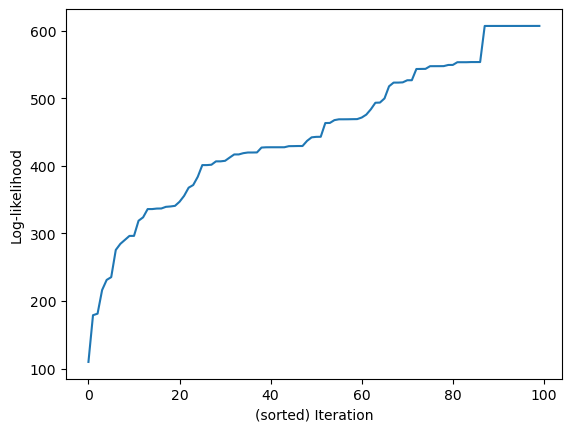

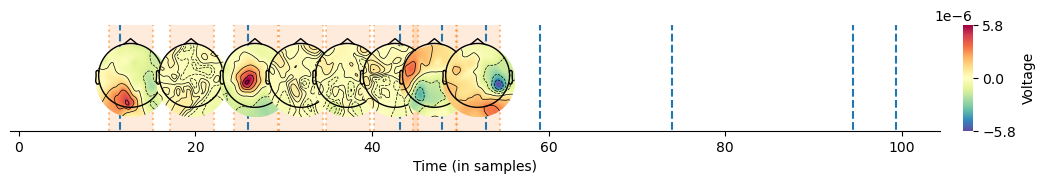

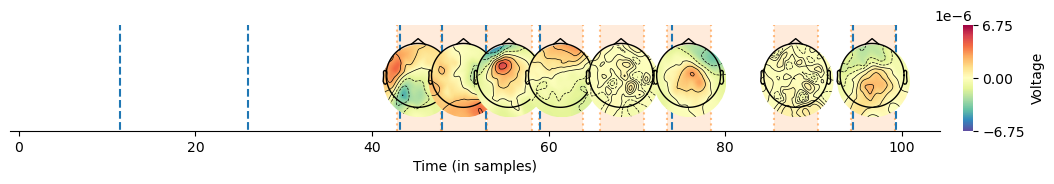

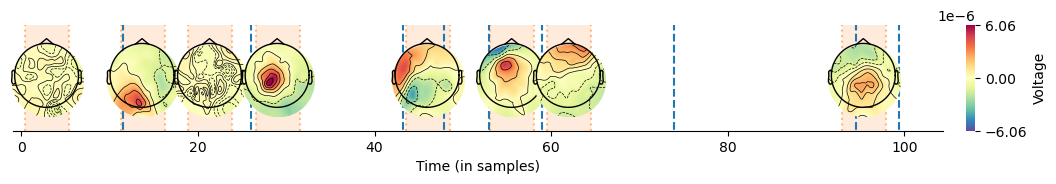

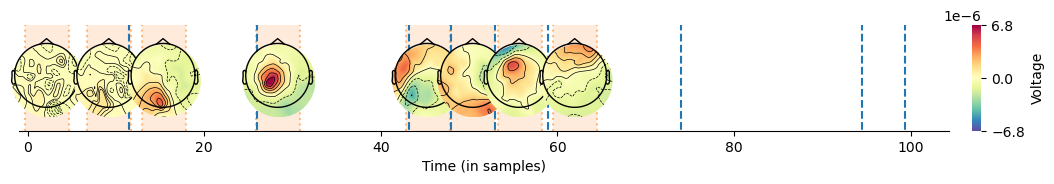

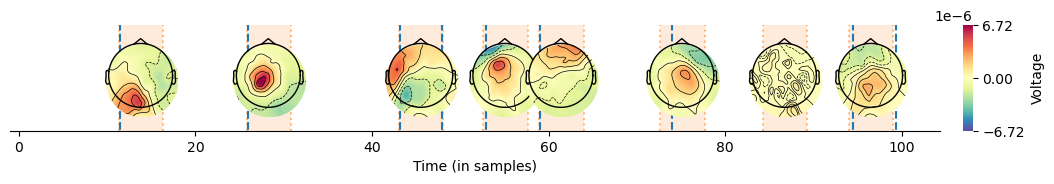

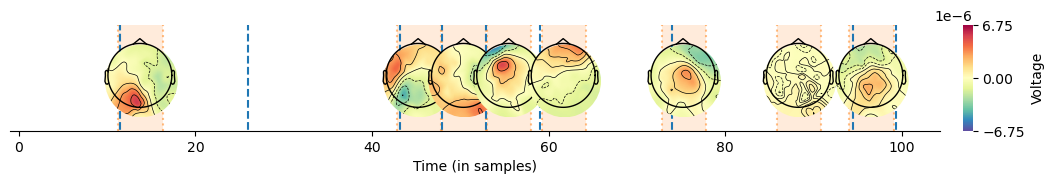

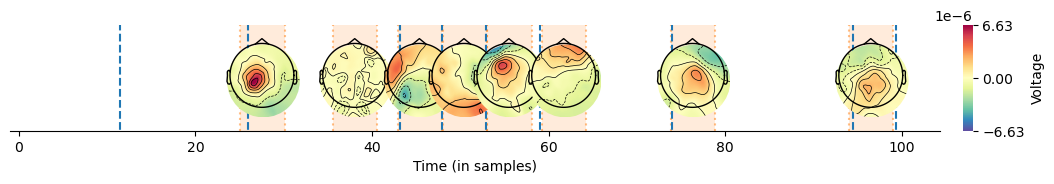

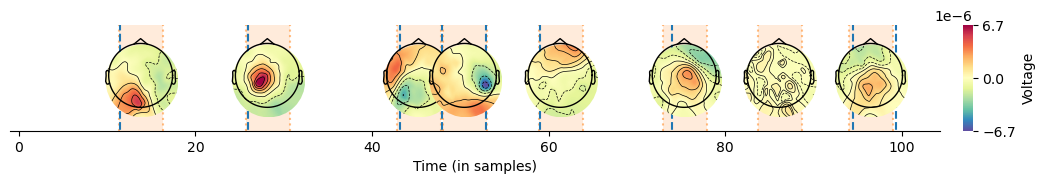

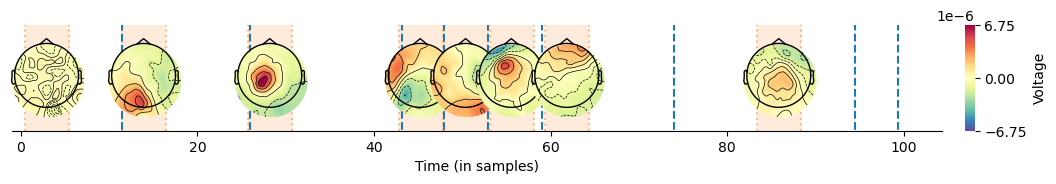

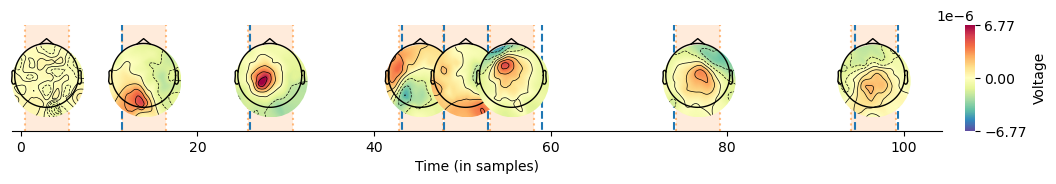

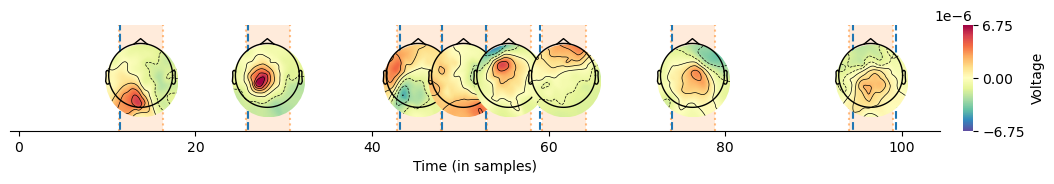

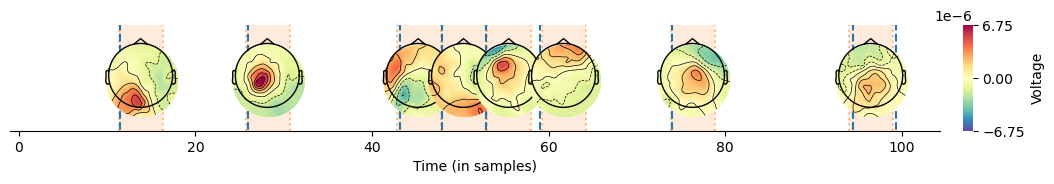

In [8]:
# Fitting
selected = init.fit_single(n_events, method='random', starting_points=100,
                           return_max=False)#function to fit an instance of a 4 events model

plt.plot(selected.sortby('likelihoods').likelihoods)#Sorted SP iteration based on log-likelihood
plt.xlabel('(sorted) Iteration')
plt.ylabel('Log-likelihood')
for iteration in selected.sortby('likelihoods').iteration[::9]:#Only plot every 9 model
    hmp.visu.plot_topo_timecourse(epoch_data, selected.sel(iteration=iteration), info, init, magnify=1, sensors=False, times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

As you can see, the higher the likelihood, the closer the discovered events are to the real events, and the most likely solution is indeed the correct one. Instead of recording all those starting points we can just take the most likely one directly by setting `return_max` to True:

Estimating 8 events model with 100 starting point(s)


  0%|          | 0/100 [00:00<?, ?it/s]

parameters estimated for 8 events model


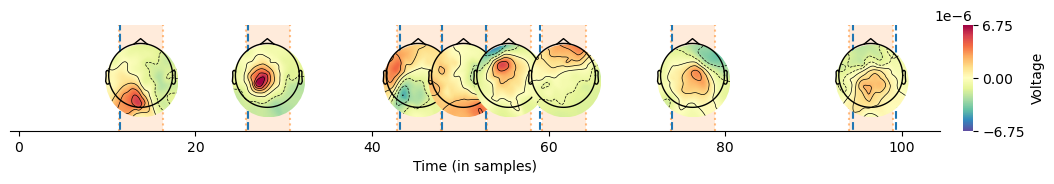

In [9]:
#NOTE: if you run this in VS code on a Mac in an interactive window, you might get strange behavior (running of previous processes) due to the multiprocessing. If so, set your multiprocessing start method to 'fork' (which is the default on Unix) by uncommenting the next two lines:
#import multiprocessing as mp
#mp.set_start_method("fork")

# Fitting
selected = init.fit_single(n_events, method='random', starting_points=100, 
                           return_max=True)#function to fit an instance of a 4 events model
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

But, by definition, the starting points are random: as a result they induce a lot of redundancy and you take the risk that some points in the parameter space remain unexplored. Several calls to this function will not always give the correct solution if not enough starting points have been provided. Below we will explore better/additional solutions to this issue.

### Exercise 2:

What good solution for this can you think of? To illustrate where we are going, fit models by subsampling from 1 to 12 events (e.g. 2, 4, 10, 12) with default starting points.

Estimating 2 events model with 1 starting point(s)
parameters estimated for 2 events model


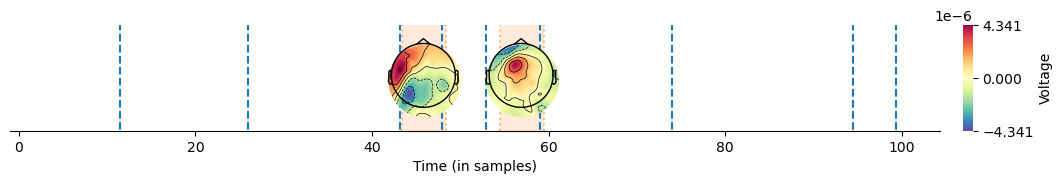

In [10]:
selected = init.fit_single(2)#Replace 2 with the desired number
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

## Backward estimation

Another solution than using random points is to first estimate a model with the maximal number of possible events that fit in RTs (referred to as 'the maximal model'), and then decrease the number of events one by one.

The idea is that genuine events will necessarily be found at the expected locations in the maximal model. Because the backward estimation method iteratively removes the weakest event (in terms of likelihood), only the 'strongest' events remain even if there location would have been hard to find with a single fit and default starting values.

In order to do this we will use the ```backward_estimation()``` function. This function first estimates the maximal model (defined based on the event width and the minimum reaction time), then estimates the max_event - 1 solution by iteratively removing one of the events and picking the next solution with the highest likelihood (for more details see Borst & Anderson, [2021](http://jelmerborst.nl/pubs/ACTR_hmp_MVPA_BorstAnderson_preprint.pdf)) and repeat this until the 1 event solution is reached. 

In [11]:
%%time 
bests = init.backward_estimation(max_events=int(init.compute_max_events()))

Estimating all solutions for maximal number of events (16) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions for 15 number of events
Estimating all solutions for 14 number of events
Estimating all solutions for 13 number of events
Estimating all solutions for 12 number of events
Estimating all solutions for 11 number of events
Estimating all solutions for 10 number of events
Estimating all solutions for 9 number of events
Estimating all solutions for 8 number of events
Estimating all solutions for 7 number of events
Estimating all solutions for 6 number of events
Estimating all solutions for 5 number of events
Estimating all solutions for 4 number of events
Estimating all solutions for 3 number of events
Estimating all solutions for 2 number of events
Estimating all solutions for 1 number of events
CPU times: user 2.67 s, sys: 1.05 s, total: 3.72 s
Wall time: 11.4 s


Here we plot the resulting solutions going from the maximal possible number of events (16) all the way to a single event. 

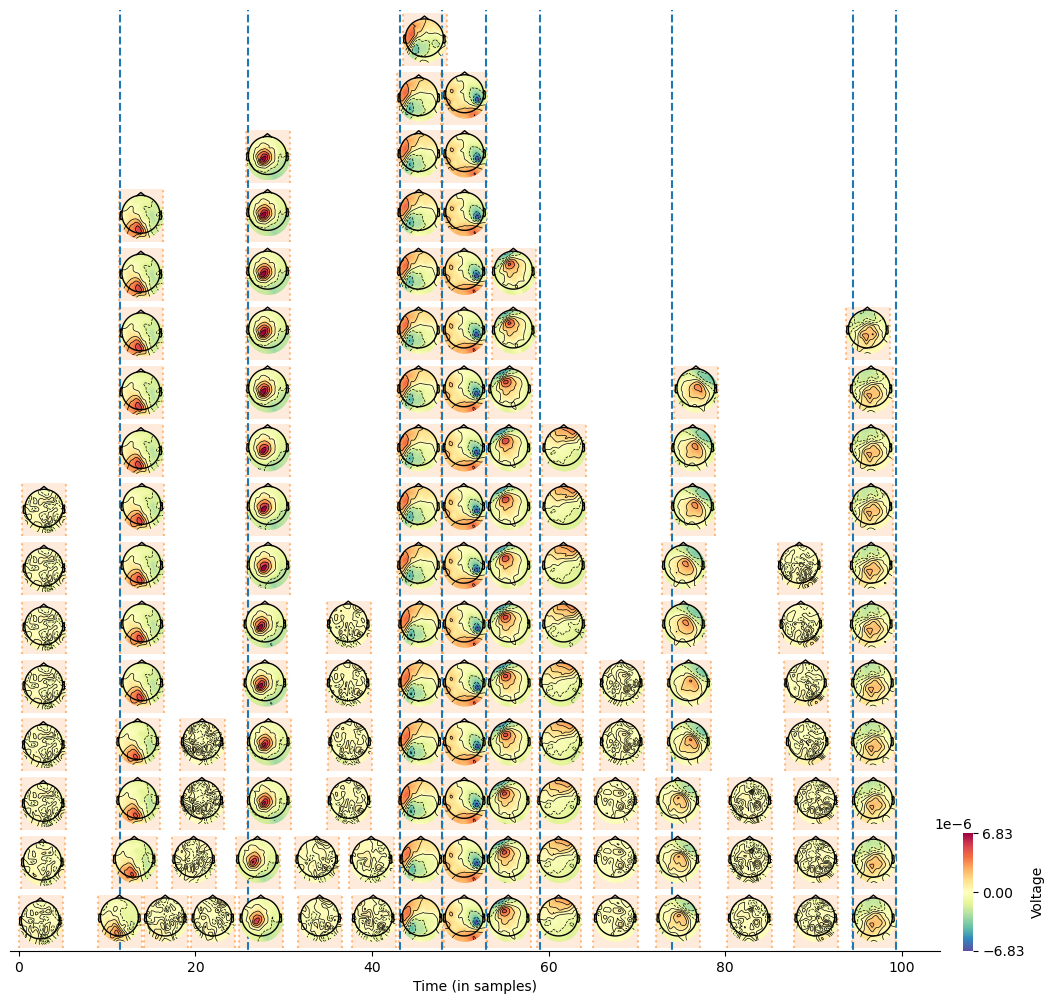

In [12]:
hmp.visu.plot_topo_timecourse(epoch_data, bests, info, init, sensors=False,
                    times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

As you can see, the 16-event solution finds the real events + some extra ones (which typically look very weak). From these solutions we can select the number of events we originally wanted to estimate (which is the correct solution in this case):

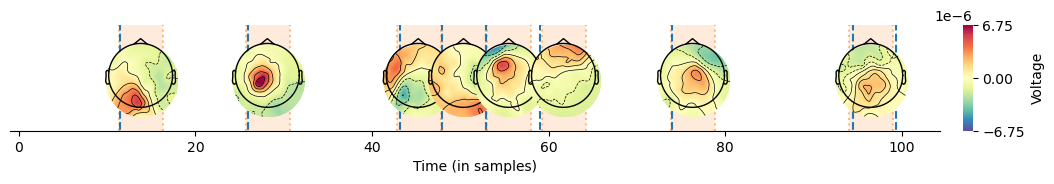

In [13]:
selected = bests.sel(n_events=n_events)
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, sensors=False,
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

The downside is that we are still unsure about whether we included all possible starting points in the mix. In addition, this method can be suboptimal with 1) long RTs and therefore a lot of events to fit and long computation times and 2) if there is a big difference between the minimum RT (determining the maximum number of events) and the mean RT (all possible locations of these events).

# Sliding events

To account for the second point in the previous comment, one possibility is to estimate a single event model and test the landing point in the log-likelihood. The sliding event method works by sliding a single event separating the mean reaction time into two stages. Discontinuities in the resulting log-likelihood usually shows that there is an event around the corresponding times. Note though that it is not a perfect process and a very high amplitude event can cover a near lower amplitude event (e.g. between sample number 18 and 25).

Fitting 99 models using grid search


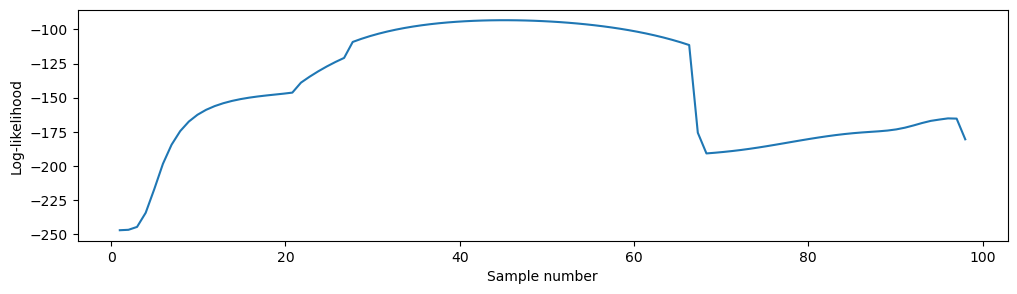

<Axes: xlabel='Sample number', ylabel='Log-likelihood'>

In [14]:
init.sliding_event(fix_pars=True)

The previous curve is obtained by fixing the parameters of the two gammas and only estimating channel contributions. We can also relax this constraint:

Fitting 33 models using grid search


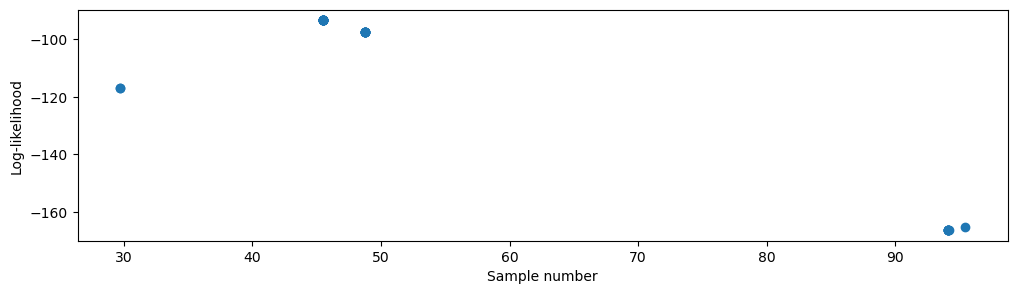

<Axes: xlabel='Sample number', ylabel='Log-likelihood'>

In [15]:
init.sliding_event(fix_pars=False, step=3)#step 3 test every 3rd sample 

Then we see that each sample number used as starting point will go to its nearest local minima. But based on the number of landing points we see, we did not capture all the events that we simulated (8). The reason is that, while we did explore the parameter space of the gammas, we didn't test for different starting points in the channel contributions. If we generate a lot of magnitudes and pass it to the ```sliding_event``` function the landing points look closer to what we expect.

To illustrate, we first generate different starting points for the 4 PC channels:

In [16]:
magnitudes_starting_points = init.gen_mags(n_events=1, decimate=3)#decimate reduces the possible number of starting points
magnitudes_starting_points[::2]

Number of potential magnitudes: 81
Because of decimation 27 will be estimated.


array([[[ 1.,  1.,  1.,  1.]],

       [[ 0., -1., -1., -1.]],

       [[-1.,  0., -1., -1.]],

       [[-1., -1.,  0., -1.]],

       [[ 1.,  1.,  1.,  0.]],

       [[-1.,  1., -1., -1.]],

       [[ 0.,  0., -1., -1.]],

       [[ 1., -1., -1., -1.]],

       [[ 0.,  1.,  0.,  1.]],

       [[-1.,  0.,  0., -1.]],

       [[ 1., -1.,  1.,  1.]],

       [[-1., -1.,  1., -1.]],

       [[-1., -1.,  0.,  0.]],

       [[-1., -1., -1.,  1.]]])

Fitting 33 models using grid search


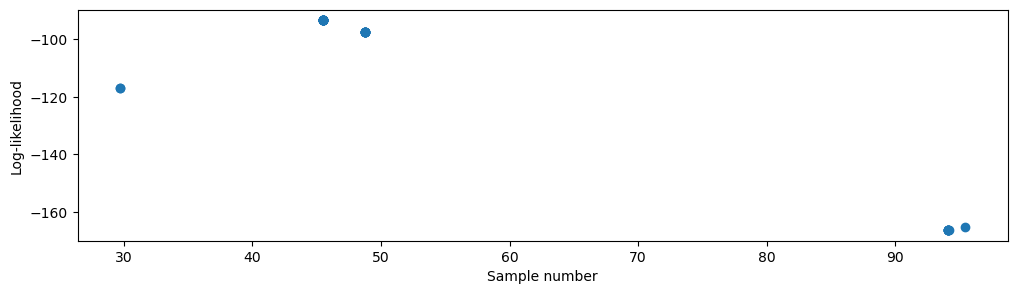

<Axes: xlabel='Sample number', ylabel='Log-likelihood'>

In [17]:
init.sliding_event(magnitudes=magnitudes_starting_points, step=3)

It appears that several landings points appear with some redundancies. To group those points together we use a clustering algorithm and make a choice on the number of clusters based on the grouping quality (silhouette coefficients and visual inspection).

First we automatically apply the method above by calling `sliding_event_mags`. Next, we cluster the events using kmeans clustering. Based on the silhoutte coefficients the method proposes an optimal number of clusters. If you agree you should enter 0, if not you can propose another number of clusters. Finally, we fit and display the model you preferred.

Number of potential magnitudes: 81
Because of decimation 27 will be estimated.


  0%|          | 0/27 [00:00<?, ?it/s]

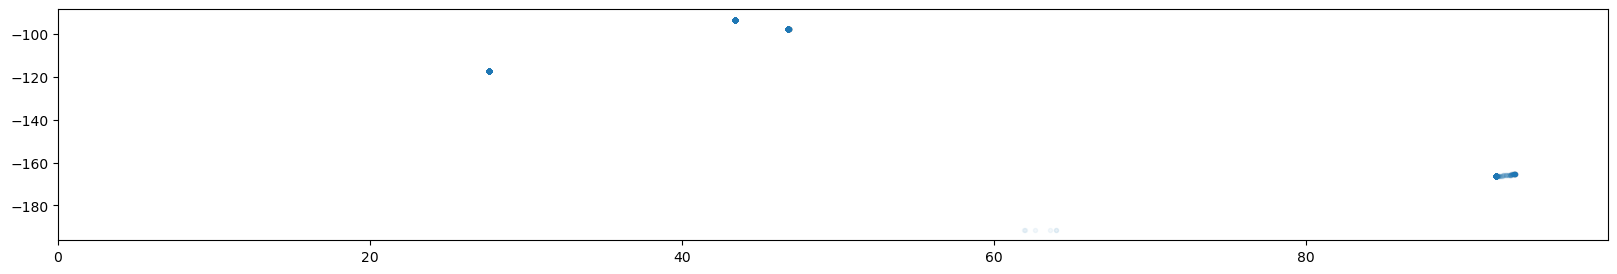

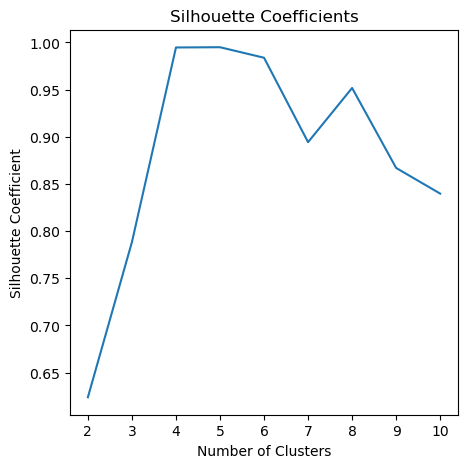

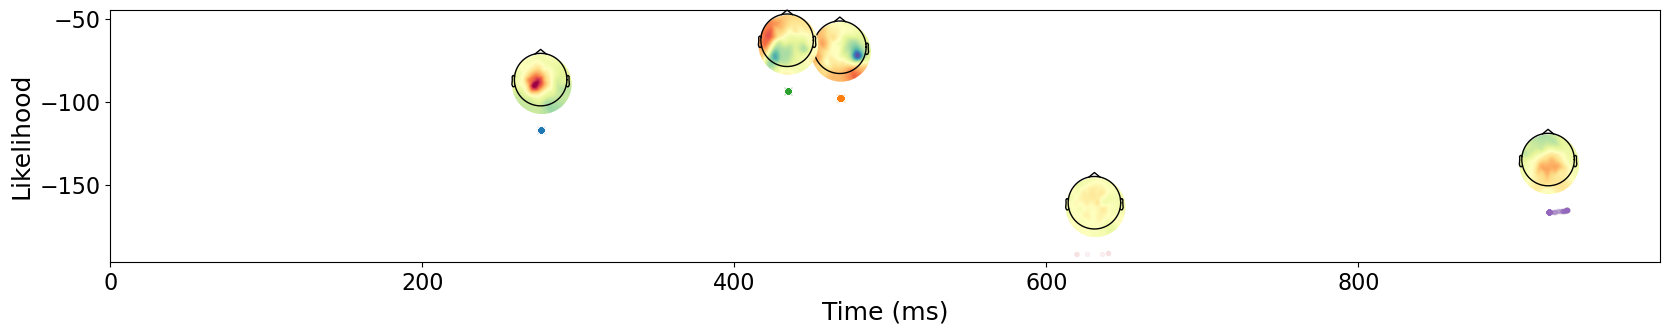

Do you agree with this solution [enter '0'], or would you like to explore a different number of clusters [enter the number of clusters]? 0


Estimating 5 events model
parameters estimated for 5 events model


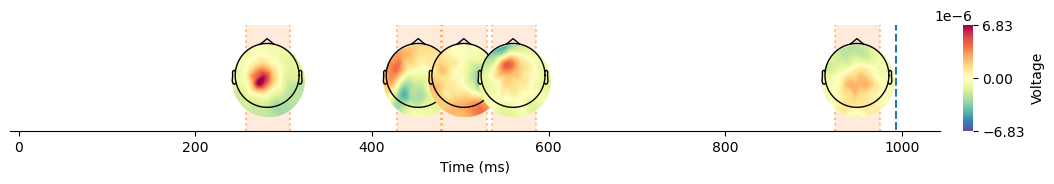

In [18]:
#calc estimates
lkhs, mags, channels, times = init.sliding_event_mags(epoch_data, step=1, decimate_grid = 3, cpu=cpus, plot=True, min_iteration=10)

# cluster in time, lkh, and mags
mags_cl, pars_cl = hmp.clusters.cluster_events(init, lkhs, mags, channels, times, method='time_x_lkh_x_mags', max_clust=10, p_outlier=.05, info=info, calc_outliers=True)

#fit final model
best_estimate = init.fit_single(mags_cl.shape[0], magnitudes=mags_cl,parameters=pars_cl)
hmp.visu.plot_topo_timecourse(epoch_data, best_estimate, info, init, magnify=1, sensors=False, time_step=1000/init.sfreq,xlabel='Time (ms)', contours=0, event_lines=True, colorbar=True)

The solution isn't yet perfect and can take quite some time depending on the number of principal components (and therefore combinations of starting points) and the number of tested clusters. One possible explanation is that not taking into account the previous events makes it harder to detect the next one (that is probably why we are missing the last one here). Therefore we created a method combining all the properties of this way of exploring the starting points:

## Cumulative event fit

Instead of fitting an _n_ event model, as the ```sliding_event()``` function, the new method starts by fitting a 1 event model (two stages) using each sample from the time 0 (stimulus onset) to the mean RT. Therefore it tests for the landing point of the expectation maximization algorithm given each sample as starting point and the likelihood associated with this landing point. As soon as a starting points reaches the convergence criterion, the function fits an _n+1_ event model and uses the next samples in the RT for the following event, etc.

  0%|          | 0/99 [00:00<?, ?it/s]

Transition event 1 found around sample 49
Transition event 2 found around sample 55
Transition event 3 found around sample 61
Transition event 4 found around sample 85
Transition event 5 found around sample 96


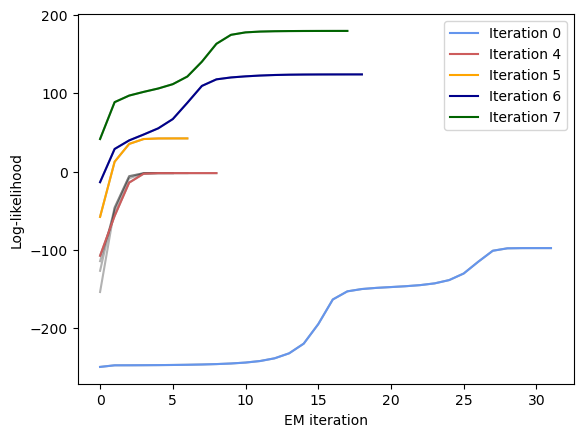

Estimating 5 events model
parameters estimated for 5 events model


In [19]:
estimates = init.fit(diagnostic=True)

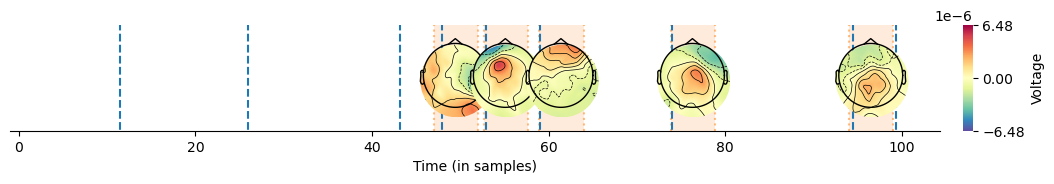

In [20]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, init, 
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

### Exercise 3:

What can cause the failure to capture the three successive events knowing that their topologies are quite similar?

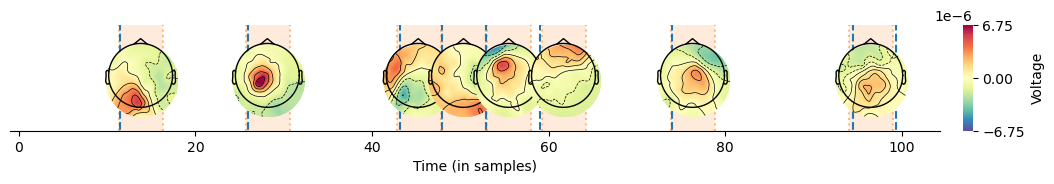

In [21]:
selected = bests.sel(n_events=n_events)
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, sensors=False,
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

If you thought of the problem, you can fix it using the code below:

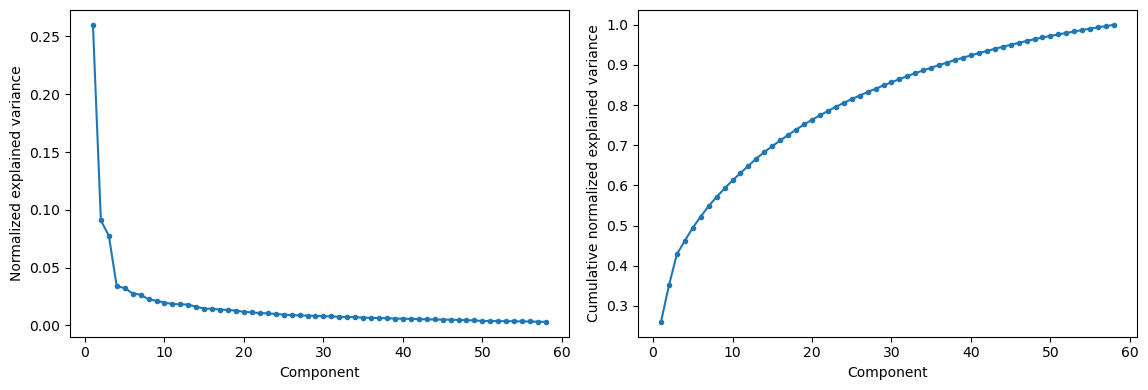

How many PCs (90 and 99% explained variance at component n37 and n55)? 5


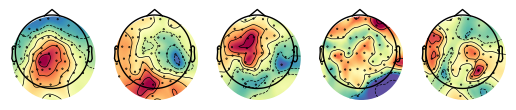

In [22]:
hmp_dat = hmp.utils.transform_data(epoch_data, apply_standard=False)
#Plot new PC selection
hmp.visu.plot_components_sensor(hmp_dat, positions=info)
#Re-Initialization of the model
init = hmp.models.hmp(hmp_dat, sfreq=epoch_data.sfreq, event_width=50, cpus=cpus)

Now, re-run the fit, and see how may events it finds.

In [23]:
estimates = init.fit()

  0%|          | 0/99 [00:00<?, ?it/s]

Transition event 1 found around sample 19
Transition event 2 found around sample 31
Transition event 3 found around sample 45
Transition event 4 found around sample 50
Transition event 5 found around sample 55
Transition event 6 found around sample 61
Transition event 7 found around sample 77
Transition event 8 found around sample 96
Estimating 8 events model
parameters estimated for 8 events model


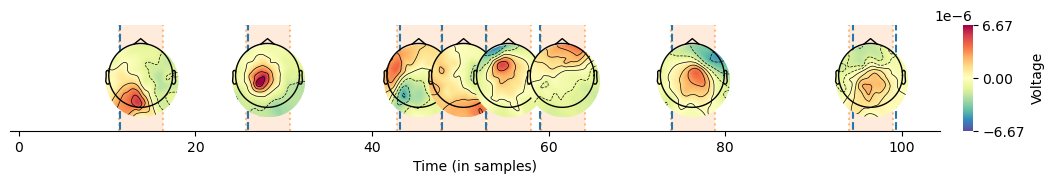

In [24]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, init, 
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

# Data saving

Once finished we can save fitted models using the dedicated command

In [25]:
hmp.utils.save_fit(selected, 'selected.nc')

selected.nc saved


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


And load the same way

In [26]:
estimates = hmp.utils.load_fit('selected.nc')

Or even only save the estimated event probabilities 

In [27]:
hmp.utils.save_eventprobs(selected.eventprobs, 'selected_eventprobs.nc')

Saved at selected_eventprobs.nc
